# Описание проекта

Мы работаем в компании "ГлавРоСНефть". Необходимо решить, где бурить скважину.
Исходные данные:<br>
id — уникальный идентификатор скважины;<br>
f0, f1, f2 — три признака точек;<br>
product — объём запасов в скважине (тыс. баррелей).<br>

Бюджет - 10 млрд. руб.<br>
1 баррель - 450 руб<br>
1 ед. - 450 тыс. руб.

### Содержание
### [1. Загрузка и подготовка данных](#section_id1)
### [2. Обучение и проверка моделей](#section_id2)
### [3. Подготовка к расчёту прибыли](#section_id3)
### [4. Расчет прибыли и рисков](#section_id4)
### [5. Вывод](#section_id5)

<a id='section_id1'></a>

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#проверим информацию по каждому столбцу по каждому региону
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Как видим, все строки в нормальном состоянии, пропусков нет.

In [9]:
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


К сожалению, заказчик утаил от нас информацию по столбцам f0, f1 и f2, поэтому будем предполагать, что с ними все хорошо. По поводу запасов видим, что медиана и среднее значение примерно одинаковы. Значит мы имеем дело с нормальным распределением.

In [10]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Здесь же по запасам нефти разница между средним и медианой ощутима (скос влево). Да и максимум запасов меньше чем в первом регионе. Проверим 3 регион.

In [11]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Есть победитель по максимальному запасу нефти. Это третий регион. Среднее и медиана равны, а значит распределение нормальное.

In [12]:
#проверим как данные коррелируют
df0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2931e0a6d0>,
      dtype=object)

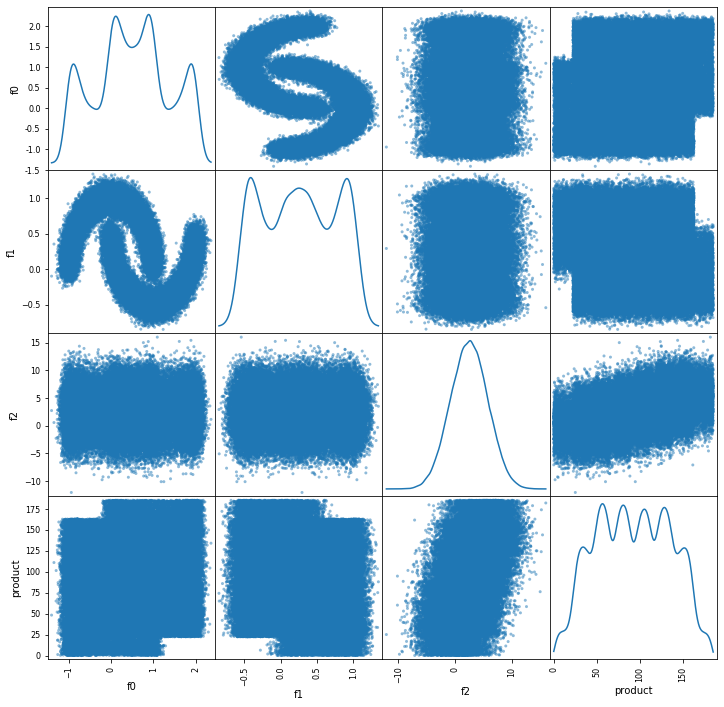

In [13]:
pd.plotting.scatter_matrix(df0, figsize=(12,12), diagonal='kde')

In [14]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f292c202d10>,
      dtype=object)

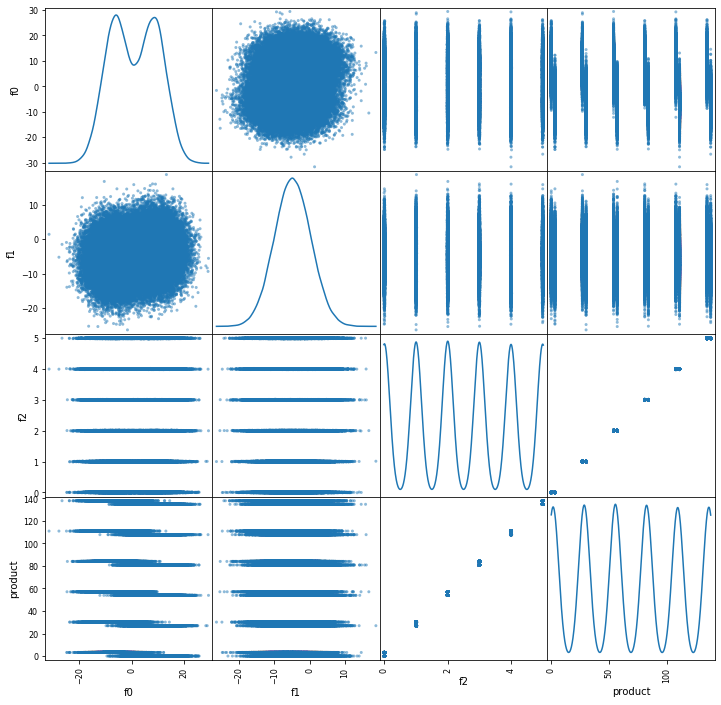

In [15]:
pd.plotting.scatter_matrix(df1, figsize=(12,12), diagonal='kde')

In [16]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f292a46ef90>,
      dtype=object)

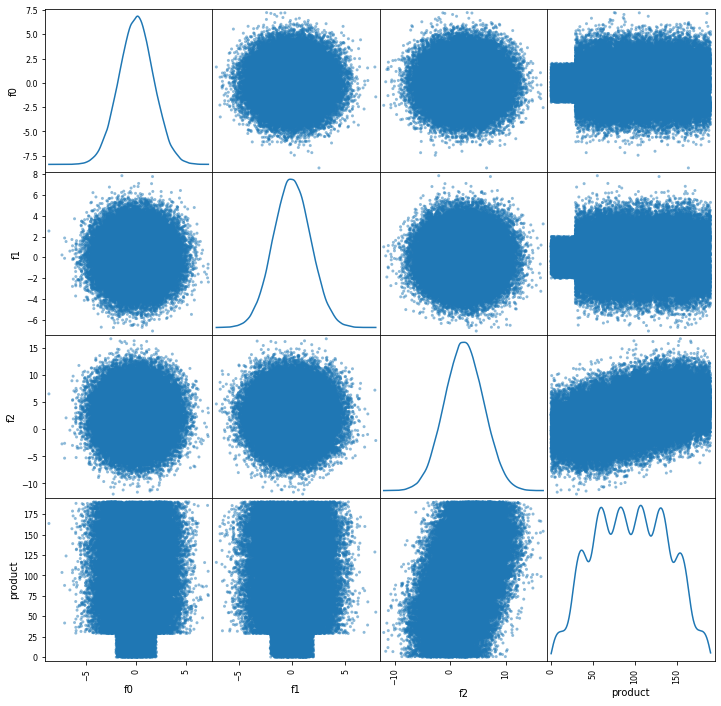

In [17]:
pd.plotting.scatter_matrix(df2, figsize=(12,12), diagonal='kde')

В результате исследования данных видим, что пустых ячеек нет, так что и удалять ничего не будем. Наибольшие объемы запасы нефти в 3 регионе 190 тыс. баррелей, наименьшие во 2 регионе 137 тыс. баррелей. У 1 и 3 регионов запаксы нефти распределены нормально, т.к. среднее и медиана равны. Смущает то, что коэф-т корреляции между f2 и product равен 0.99 во втором регионе (может конечно это и норма, ибо мы не знаем что за признаки f0,f1,f2 но они значимы, поэтому тогда оставим). Также перед началом обучения можно удалить столбцы id -уникальный идентификатор скважины (от данного признака модель лучше или хуже работать точно не станет ибо он уникальный для каждой скважины).

In [18]:
df0 = df0.drop(['id'], axis=1)
df0

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
99995,0.971957,0.370953,6.075346,110.744026
99996,1.392429,-0.382606,1.273912,122.346843
99997,1.029585,0.018787,-1.348308,64.375443
99998,0.998163,-0.528582,1.583869,74.040764


In [19]:
df1 = df1.drop(['id'], axis=1)
df1

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...
99995,9.535637,-6.878139,1.998296,53.906522
99996,-10.160631,-12.558096,5.005581,137.945408
99997,-7.378891,-3.084104,4.998651,137.945408
99998,0.665714,-6.152593,1.000146,30.132364


In [20]:
df2 = df2.drop(['id'], axis=1)
df2

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046
99996,-1.261523,-0.894828,2.524545,138.748846
99997,-1.199934,-2.957637,5.219411,157.080080
99998,-2.419896,2.417221,-5.548444,51.795253


<a id='section_id2'></a>

# 2. Обучение и проверка модели

In [21]:
#разделим выборки на обучающую и валидационную, для этого надо написать функцию, т.к. мы имеем 3 региона
def train_valid(df, col_name):
    features = df.drop([col_name], axis=1)
    target = df[col_name]
    features_train , features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, random_state=12345)
    #далее необходимо отмасштабировать 3 признака, чтобы они все были значимыми
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid

In [22]:
features0_train, features0_valid, target0_train, target0_valid = train_valid(df0, 'product')
features1_train, features1_valid, target1_train, target1_valid = train_valid(df1, 'product')
features2_train, features2_valid, target2_train, target2_valid = train_valid(df2, 'product')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

Таблицу разделили и стандартизировали по 3 регионам. Следующий этап обучение модели

In [23]:
#напишем функцию для машинного обучения (линейная регрессия)
def machine_learning(features_train, features_valid, target_train, target_valid, i):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions_valid)
    rmse = mse ** .5
    predict_mean = predictions_valid.mean()
    print(f'{i} регион')
    print('|{: ^12}|{: ^12}|{: ^12}|' .format('Predict_mean', 'MSE', 'RMSE'))
    print('|{: ^12.5f}|{: ^12.5f}|{: ^12.5f}|' .format(predict_mean, mse, rmse))
    return predictions_valid, rmse

In [24]:
predictions0_valid, rmse0 = machine_learning(features0_train, features0_valid, target0_train, target0_valid, 1)

1 регион
|Predict_mean|    MSE     |    RMSE    |
|  92.59257  | 1412.21294 |  37.57942  |


In [25]:
predictions1_valid, rmse1 = machine_learning(features1_train, features1_valid, target1_train, target1_valid, 2)

2 регион
|Predict_mean|    MSE     |    RMSE    |
|  68.72855  |  0.79763   |  0.89310   |


In [26]:
predictions2_valid, rmse2 = machine_learning(features2_train, features2_valid, target2_train, target2_valid, 3)

3 регион
|Predict_mean|    MSE     |    RMSE    |
|  94.96505  | 1602.37758 |  40.02971  |


В данном пункте была применена модель "линейная регрессия". Наш датасет был разбит на обучающую и валидационную выборки соотношение 4:1. Была проведена стандартизация признаков, чтобы исключить большой дисбаланс чисел. По результатам машинного обучения наибольшее отклонение получилось в 1 и 3 регионах показав практически идентичный результат (37,5 и 40). Во 2 регионе стандартное отклонение получилось меньше единицы (возможно там имеется наименьший разброс между объемами нефти в скважинах). Однако, по результатам машинного обучения, средние показатели объема нефти в скважинах совпадают с нашими исходными датасетами. На основании этого, можем считать, что модель наша предсказывает с очень хорошей точностью (но тут скорее всего заслуга исходных данных, а не моя :-) )

<a id='section_id3'></a>

# 3. Подготовка к расчёту прибыли

In [27]:
#введем наши дополнительные переменные
budget = 1e10 #10 млрд. руб.
barrel_1_crude = 450 # 450 руб
income_1_product = 4.5e5 # получается 1000 баррель 450 тыс. руб
points = 500
profitable_points = 200

In [28]:
#рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
volume_1_product = budget / (income_1_product * profitable_points)
volume_1_product

111.11111111111111

Для безубыточности разработки новой скважины, необходимо чтобы там было не менее 111 единиц продукта (111111 баррелей). По предсказаниям модели, лучший регион это третий, но и там среднее значение 95 тыс единиц, что нас тоже не устраивает (но благо у нас этих скважин в каждом регионе по 100 тыс и оттуда мы сможем выбрать 200 наиболее прибыльных). Будем проводить бутстрап.

<a id='section_id4'></a>

# 4. Расчёт прибыли и рисков 

In [29]:
#перед тем как писать функцию и рассчитывать прибыль, необходимо массив предсказанной модели перевести в Series 
#(я думаю это нужно, чтобы знать индексы скважин из генеральной совокупности, так мы можем посмотреть хар-ки)
predict0_valid = pd.Series(predictions0_valid, index=features0_valid.index)
predict1_valid = pd.Series(predictions1_valid, index=features1_valid.index)
predict2_valid = pd.Series(predictions2_valid, index=features2_valid.index)

In [30]:
#для расчета прибыли напишем функцию, которая отсортирует наш массив с предсказаниямив порядке убывания и 
#просуммируем объем скважин первых 200 точек
def profit(df, n):
    df = df.sort_values(ascending=False)
    total_volume = 0
    for i in range(0, profitable_points, 1): #используем 200 наиболее прибыльных скважин
        total_volume += df.iloc[i]
    total_profit = (total_volume * income_1_product) - budget
    print('Прибыль с {: 2} региона составляет {:.2f} рублей' .format(n, total_profit))
    return total_profit

In [31]:
total_profit0 = profit(predict0_valid, 1)
total_profit1 = profit(predict1_valid, 2)
total_profit2 = profit(predict2_valid, 3)

Прибыль с  1 региона составляет 3996048877.47 рублей
Прибыль с  2 региона составляет 2485712051.97 рублей
Прибыль с  3 региона составляет 3321754396.24 рублей


Итак, в данной части по валидационной выборке мы выбрали 200 наиболее прибыльных скважин по каждому из регионов. Были посчитаны суммарные их объемы нефтепродуктов и посчитана прибыль. Наиболее прибыльным считается 1 регион (практически 4 млрд руб).

Далее проведем анализ рисков

In [32]:
state = np.random.RandomState(12345)

In [33]:
def revenue(predict, target, n):
    predict_sort = predict.sort_values(ascending=False)
    selected = target[predict_sort.index][:n]
    total_rev_loss = selected.sum() * income_1_product - budget
    return total_rev_loss

In [34]:
#для анализа рисков проведем бутсрапирование извлекая по 500 скважин и находя срендюю прибыль 200 наибольших по объему скважин
def bootstrap(predict, target):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=points, replace=True, random_state=state) #извлекаем 500 точек
        predict_subsample = predict[target_subsample.index]
        values.append(revenue(predict_subsample, target_subsample, profitable_points)) #находим прибыль(убыток) 200 наболее больших скважин
    return values    

In [35]:
values0 = bootstrap(predict0_valid, target0_valid)
values1 = bootstrap(predict1_valid, target1_valid)
values2 = bootstrap(predict2_valid, target2_valid)

In [36]:
values0 = pd.Series(values0)
values1 = pd.Series(values1)
values2 = pd.Series(values2)

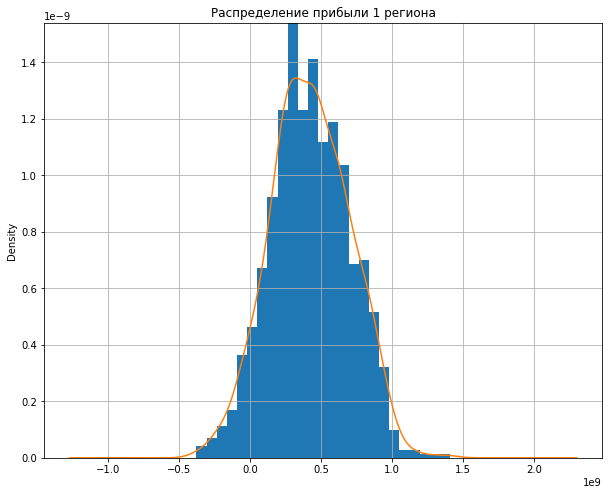

In [37]:
values0.hist(density=True, bins=25)
values0.plot(kind='kde', title='Распределение прибыли 1 региона', figsize=(10,8), grid=True)

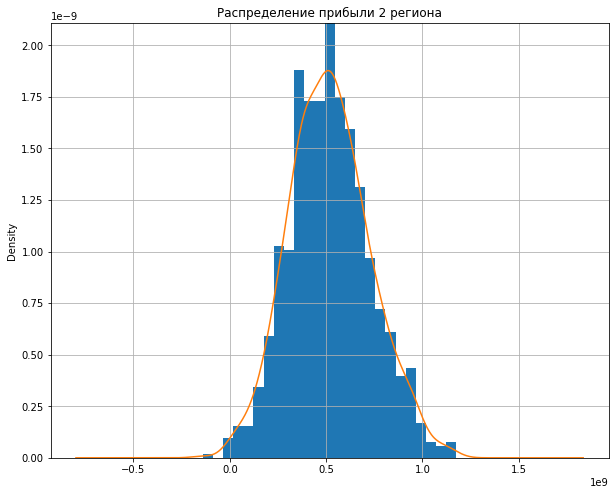

In [38]:
values1.hist(density=True, bins=25)
values1.plot(kind='kde', title='Распределение прибыли 2 региона', figsize=(10,8), grid=True)

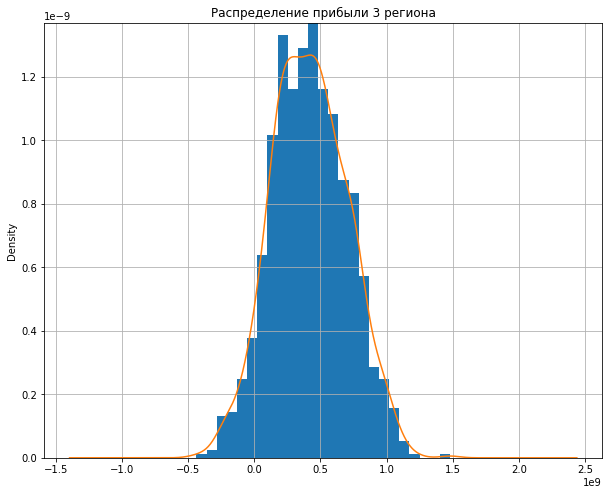

In [39]:
values2.hist(density=True, bins=25)
values2.plot(kind='kde', title='Распределение прибыли 3 региона', figsize=(10,8), grid=True)

In [40]:
#напишем функцию, которая считает срднее значение прибыли и строит 95% доверительный интервал
def mean_and_interval(values, n):
    print(f'Среднее значение прибыли региона {n}: ', values.mean())
    #посчитаем 95% интервал
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    print("95%-ый доверительный интервал:", confidence_interval)

In [41]:
def quantile(values, number):
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(f'{number} регион')
    print('2,5% квантиль', lower)
    print('97,5% квантиль', upper)
    return lower, upper

In [42]:
mean_and_interval(values0, 1)

Среднее значение прибыли региона 1:  425938526.9105923
95%-ый доверительный интервал: (408732207.0686985, 443144846.7524861)


In [43]:
lower0, upper0 = quantile(values0, 1)

1 регион
2,5% квантиль -102090094.83793654
97,5% квантиль 947976353.358369


In [44]:
mean_and_interval(values1, 2)

Среднее значение прибыли региона 2:  518259493.69732493
95%-ый доверительный интервал: (505249881.5766218, 531269105.8180281)


In [45]:
lower1, upper1 = quantile(values1, 2)

2 регион
2,5% квантиль 128123231.43308629
97,5% квантиль 953612982.0669085


In [46]:
mean_and_interval(values2, 3)

Среднее значение прибыли региона 3:  420194005.34405005
95%-ый доверительный интервал: (402528703.6503615, 437859307.0377386)


In [47]:
lower2, upper2 = quantile(values2, 3)

3 регион
2,5% квантиль -115852609.16001143
97,5% квантиль 989629939.844574


In [48]:
print('Вероятность убытков в 1 регионе {:.2f} %'.format(100 * values0.loc[values0<0].count() / values0.count()))

Вероятность убытков в 1 регионе 6.00 %


In [49]:
print('Вероятность убытков во 2 регионе {:.2f} %'.format(100 * values1.loc[values1<0].count() / values1.count()))

Вероятность убытков во 2 регионе 0.30 %


In [50]:
print('Вероятность убытков в 3 регионе {:.2f} %'.format(100 * values2.loc[values2<0].count() / values2.count()))

Вероятность убытков в 3 регионе 6.20 %


<a id='section_id5'></a>

# Вывод

Нам была поставлена задача изучить наиболее прибыльный регион для разработки скважин. Для этого нам дали исходные данные 3 регионов, в каждом из котором имелось по 100 тыс скважин. Имелся бюджет в 10 млрд. руб. Цена 1 барреля 450 руб, 1 единицы 450 тыс руб. Нами было проведено машинное обучение методом линейной регрессии. Но перед этим мы подготовили данные, именно стандартизировали 3 признака, чтобы они все имели одинаковую значимость. После машинного обучения, мы сравнили значения правильных ответов с предказаниями. В итоге получили, что стандартное отклонение в 1 и 3 регионах составляют 37,5 и 40 тыс баррелей, что прилично (видимо это связано с большим разбросом залежей нефтепродуктов). Во 2 регионе стандартное отклонение 0,89 тыс баррелей. Однако средние показатели соответствуют исходным данным.

Для безубыточной разработки сырья нам необходимо добыть 1111,111 тыс баррелей сырья при бюджете в 10 млрд. руб (200 скважин - так задано в условии задачи). Прибыль с 1 первого региона используя только первые 200 скважин получим 4 млрд. руб, 2 регион 2,5 млрд, 3 регион 3,3 млрд руб. В этой части 1 регион предпочтительнее.

Далее мы использовали метод бутстрапирования, извлекая по 500 скважин из валидационной выборки размером 25 тыс скважин, из них выделяли 200 наиболее прибыльных и находили среднее значение. В итоге по среднему показателю предпочтение отдается 2 региону (5.2 млрд. руб). 1 и 3 регионы показывают практические идентичные результаты (4,3 и 4,2 млрд руб.). Беря 2,5% квантиль 1 и 3 регионы идут в убыток, чего нельзя сказать про 2 регион, который в плюсе. Также у 1 и 3 регионов одинаковые вероятности убытков (по 6% т.е. на 1000 вариантов - 60 показателей убыточные).

Итак, по результатам работы наиболее оптимальным выбором является 2 регион (Хорошие показатели средней прибыли, 2,5% квантиль составляет 128 млн. руб, вероятность убытков 0,3%).